参考：[函数调用过程探究](https://www.cnblogs.com/bangerlee/archive/2012/05/22/2508772.html)


对于有特定用途的几个寄存器，简要介绍如下：

- ax(accumulator): 可用于存放函数返回值
- bp(base pointer): 用于存放执行中的函数对应的栈帧的栈底地址
- sp(stack poinger): 用于存放执行中的函数对应的栈帧的栈顶地址
- ip(instruction pointer): 指向当前执行指令的下一条指令
 

不同架构的CPU，寄存器名称被添以不同前缀以指示寄存器的大小。例如对于x86架构，字母“e”用作名称前缀，指示各寄存器大小为32位；对于x86_64寄存器，字母“r”用作名称前缀，指示各寄存器大小为64位。


In [ ]:
主要想看下下面这两行的含义
push   %rbp
mov    %rsp,%rbp

从栈帧的表现看，主要目的是为了函数返回时候，能从被调函数恢复到调用函数的状态

In [2]:
"""

示例代码：

//func_call.cint bar(int c, int d)
{
    int e = c + d;
    return e;
}
int foo(int a, int b)
{
    return bar(a, b);
}
int main(void)
{
    foo(2, 5);
    return 0;
}

"""


'\n\n示例代码：\n\n//func_call.cint bar(int c, int d)\n{\n    int e = c + d;\n    return e;\n}\nint foo(int a, int b)\n{\n    return bar(a, b);\n}\nint main(void)\n{\n    foo(2, 5);\n    return 0;\n}\n\n'

In [ ]:
调用 foo()之前，%rbp=%rsp
注意 call 调用的下一句地址：  0x0000555555555181
(gdb) i r rbp rsp rip
rbp            0x7fffffffd6f0      0x7fffffffd6f0
rsp            0x7fffffffd6f0      0x7fffffffd6f0
rip            0x55555555517c      0x55555555517c <main+18>


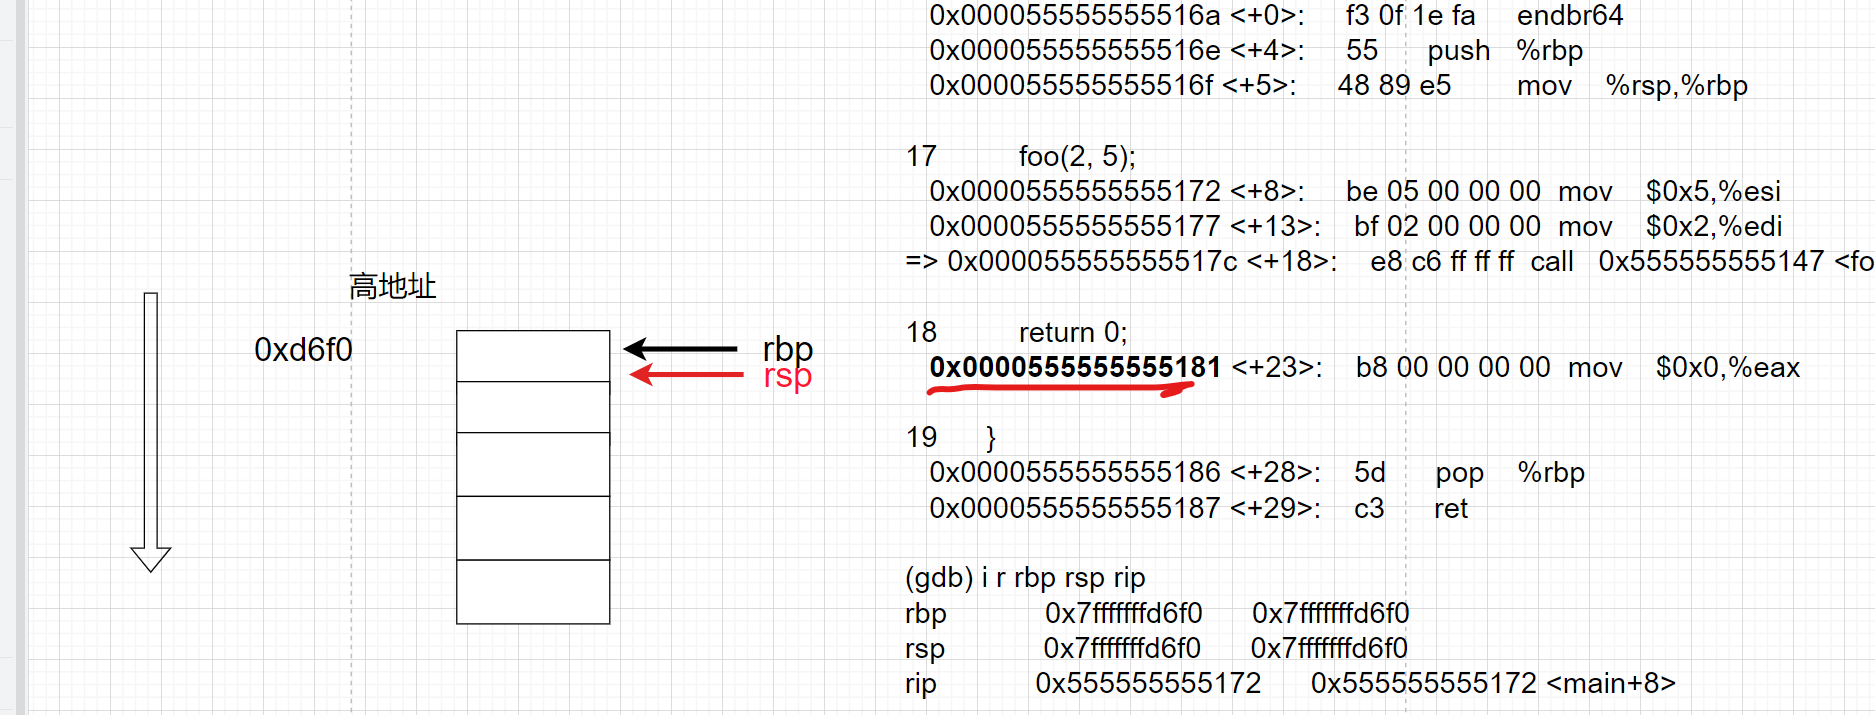


随后，单步调试：
执行call 调用，可以看到 rsp %rsp 的地址值 减小了，
也就是栈扩展了 8字节


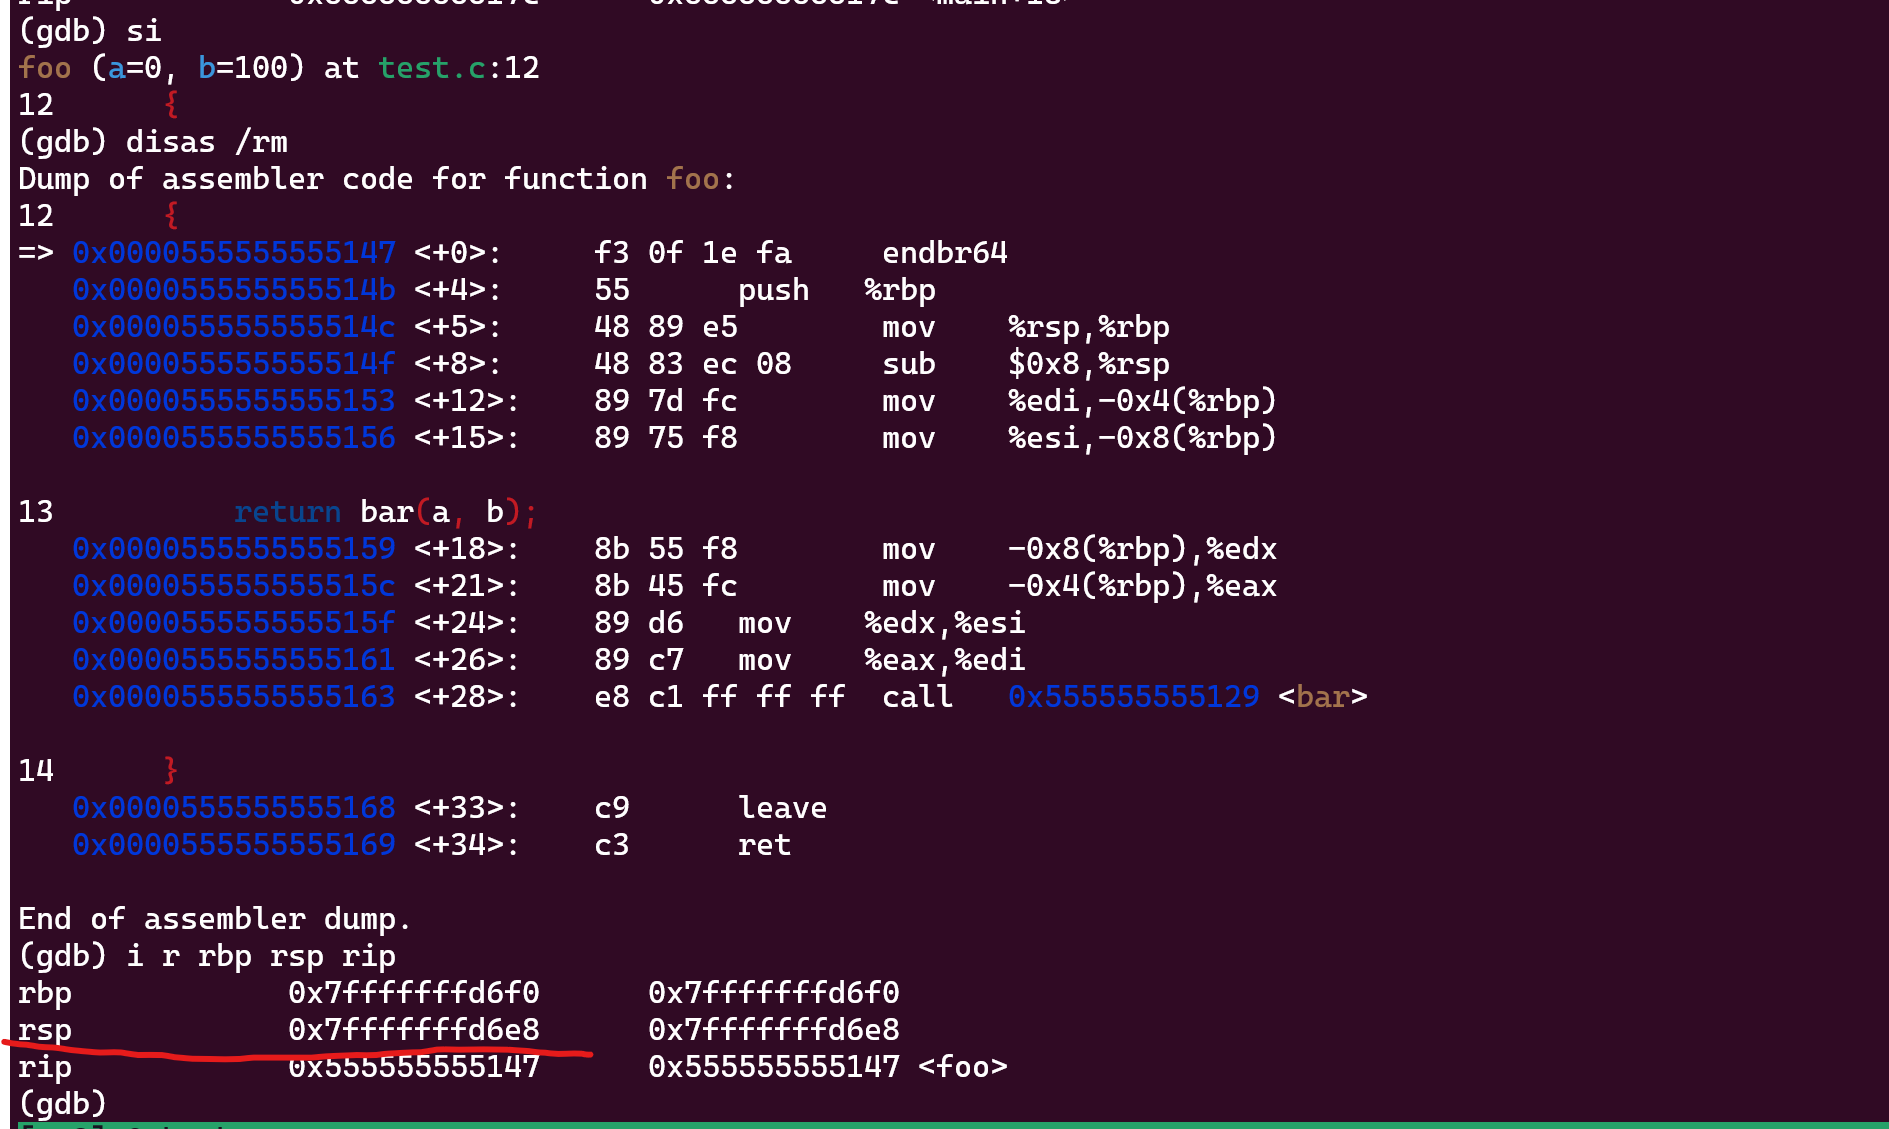

In [ ]:
可以通过 %rsp 朝后看4个单位（每个单位2字节），查看内存里的内容，如下：

(gdb) x/4dh 0x7fffffffd6e8
0x7fffffffd6e8: 20865   21845   21845   0
(gdb)          0x5181  0x5555   0x5555  0x0

改值正好与 调用 foo() 的下一条指令地址 0x0000555555555181 相吻合：

=> 0x000055555555517c <+18>:    e8 c6 ff ff ff  call   0x555555555147 <foo>

18          return 0;
   0x0000555555555181 <+23>:    b8 00 00 00 00  mov    $0x0,%eax


也即，调用函数跳转前，会执行将下一条指令地址压栈的操作：
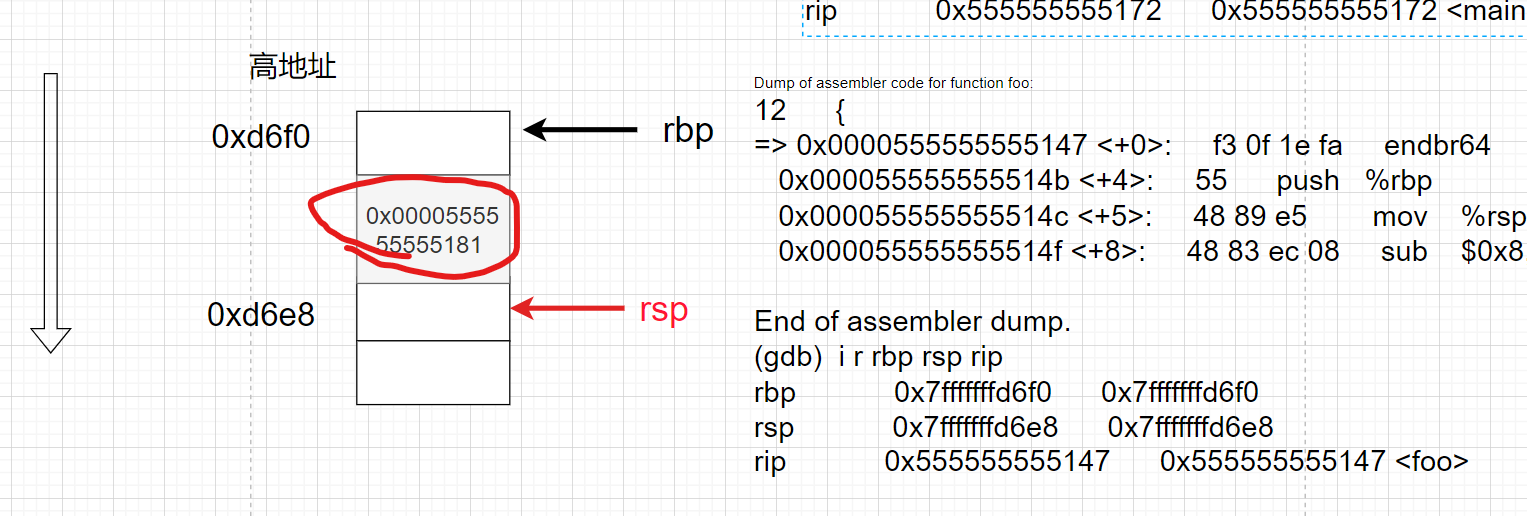

### push   %rbp

In [ ]:
随后，跳转到 foo(),

执行 
   0x000055555555514b <+4>:     55      push   %rbp
(gdb) i r rbp rsp rip
rbp            0x7fffffffd6f0      0x7fffffffd6f0
rsp            0x7fffffffd6e0      0x7fffffffd6e0
rip            0x55555555514c      0x55555555514c <foo+5>
栈帧 情况如下

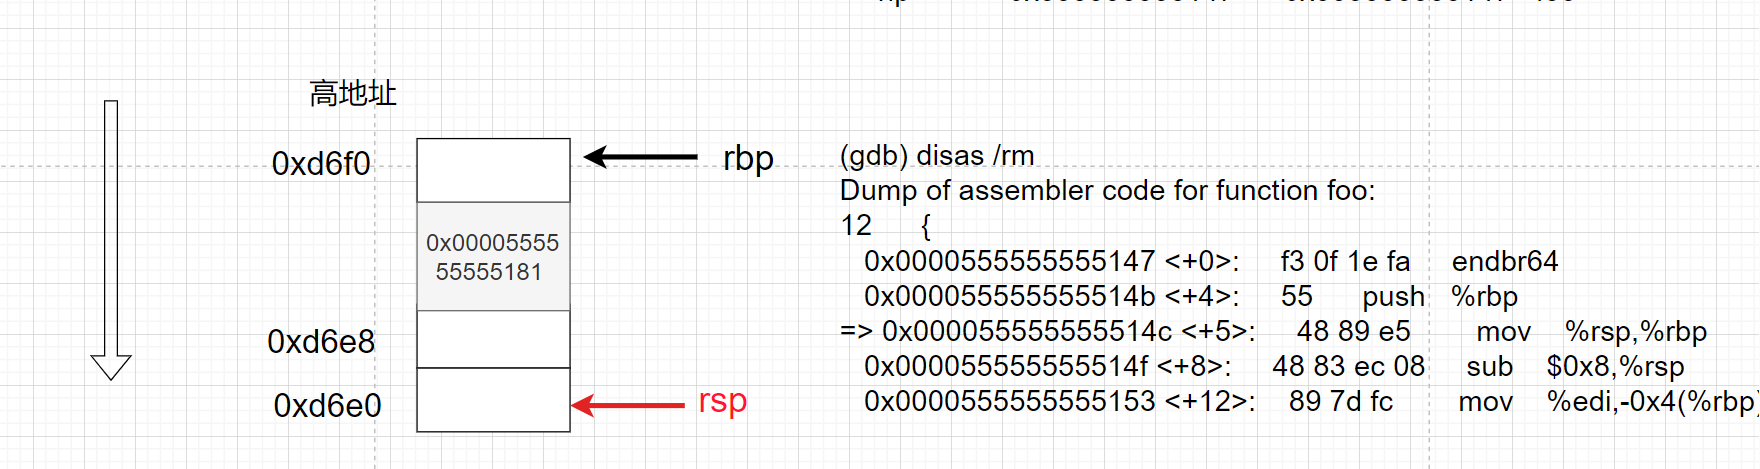

###  mov    %rsp,%rbp

In [ ]:
执行 mov    %rsp,%rbp

   0x000055555555514b <+4>:     55      push   %rbp
   0x000055555555514c <+5>:     48 89 e5        mov    %rsp,%rbp
    
=> 0x000055555555514f <+8>:     48 83 ec 08     sub    $0x8,%rsp

(gdb) i r rbp rsp rip
rbp            0x7fffffffd6e0      0x7fffffffd6e0
rsp            0x7fffffffd6e0      0x7fffffffd6e0
rip            0x55555555514f      0x55555555514f <foo+8>

%rsp,%rbp 值 对齐

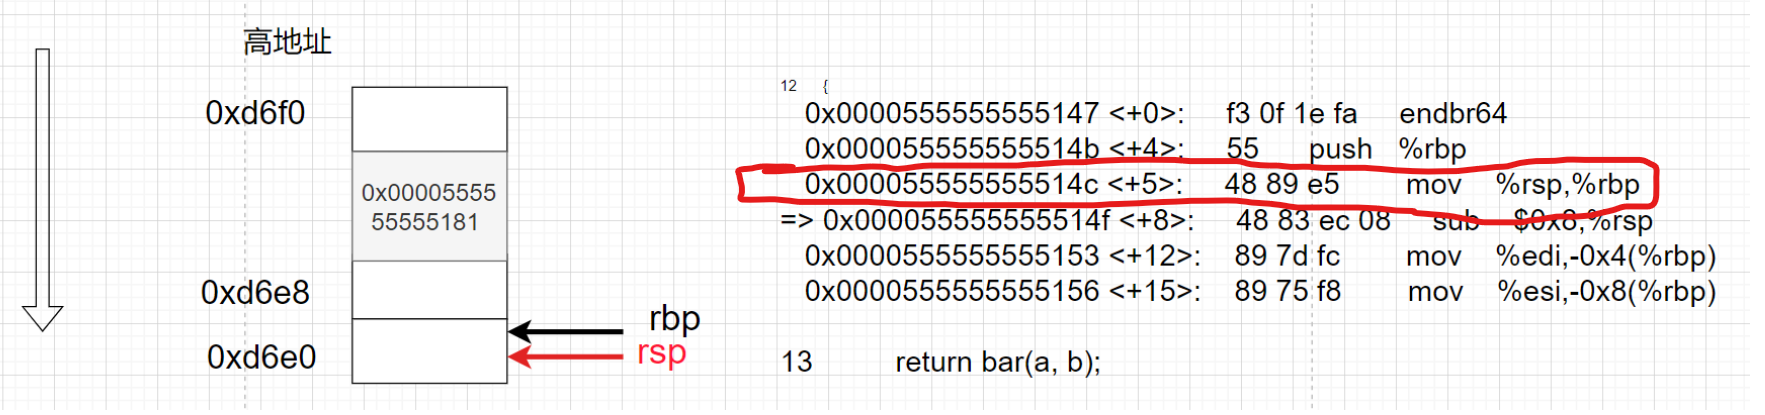